# CSE 447/517: Python and Math tutorial

Author: Jaehun Jung, Alisa Liu

In this tutorial, we will go through some of the basic concepts behind Language Models and how to implement them in Python (Numpy and Torch). The topics covered include:
* **Categorical distribution** and how to sample from them
* Basic **Information theory**: Entropy, Cross Entropy, and KL Divergence
* **Language Model** as an empirical distribution of human text
* Basic **Decoding methods**: what it means to generate a sequence, and how to generate a text sequence from a Language Model

## Before we start
Make sure to copy this jupyter notebook into your drive!

## Part 1: Categorical Distribution

### What is a categorical distribution?

**Categorical distribution** is a discrete probability distribution, that describes the possible results of a random variable that can take on one of K possible categories.

An intuitive example: Outcomes of rolling a dice

![](https://drive.google.com/uc?export=view&id=1pJ32TgBEirKS7WLnCMkluW-uBF2eAekC)




### Example: Favorite ice cream flavor

We want to sell ice creams to UW students. To get a better sense of what flavors are popular, we conducted a survey on 20 students' favorite ice-cream flavor. There are 4 options: Chocolate, Strawberry, Mango and Vanilla.

In [ ]:
survey_result = ['chocolate', 'chocolate', 'vanilla', 'strawberry',
                 'strawberry', 'vanilla', 'chocolate', 'vanilla',
                 'mango', 'vanilla', 'vanilla', 'chocolate',
                 'strawberry', 'chocolate', 'mango', 'vanilla',
                 'strawberry', 'strawberry', 'vanilla', 'mango']

We can represent this into a categorical distribution, by computing the probability of each flavor in the survey result.

In [ ]:
flavor_distribution = {
    flavor: survey_result.count(flavor) / len(survey_result) # the number of occurrences of each flavor divided by the number of all samples
    for flavor in survey_result
}

flavor_distribution

{'chocolate': 0.25, 'vanilla': 0.35, 'strawberry': 0.25, 'mango': 0.15}

We can draw a plot of this distribution using matplotlib, a popular python library for plotting graphs.

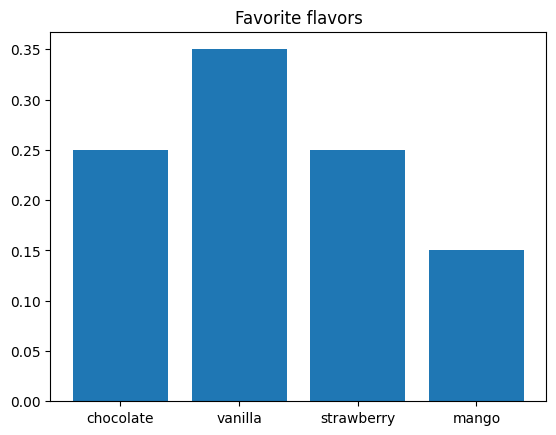

In [ ]:
import matplotlib.pyplot as plt


def draw_histogram(distribution: dict, title: str):
  categories = list(distribution.keys())
  values = list(distribution.values())

  plt.bar(categories, values)
  plt.title(title)

draw_histogram(flavor_distribution, "Favorite flavors")

### Sampling from Categorical Distribution

We understand what categorical distribution is, but how do we **sample** from it? With native python, you can use `random.choices` function:

In [ ]:
import random

flavor_categories = list(flavor_distribution.keys())
flavor_probabilities = list(flavor_distribution.values())

print(random.choices(flavor_categories, weights=flavor_probabilities)[0])

vanilla


You can also sample multiple samples at once, by specifying `k` parameter:

In [ ]:
print(random.choices(flavor_categories, weights=flavor_probabilities, k=3))

['vanilla', 'vanilla', 'vanilla']


### Faster sampling with Torch

The ice-cream distribution only had 4 categories. What if we have > 10000 categories (e.g. all english words)? In this case, sampling with `random.choices` may take too long...

Instead, you can use `torch.multinomial`, which provides a faster implementation of categorical distribution.

In [ ]:
import time

large_categories = range(int(1e6))  # each category is represented as an integer in [0, 999999]
large_probabilities = [1/1e6] * int(1e6)  # all 1000000 categories get equal probability of 0.000001

start_time = time.time()
print(random.choices(large_categories, weights=large_probabilities, k=100))
print(f"--- random.choices : {time.time() - start_time} seconds ---")

[731841, 871727, 894177, 528107, 232734, 28590, 654532, 169776, 245674, 436269, 323195, 546442, 705515, 787654, 944307, 373448, 112482, 878434, 547639, 418052, 148286, 595612, 375769, 842913, 206572, 540335, 247660, 591954, 104700, 552319, 31193, 772652, 147407, 514045, 593624, 43167, 732344, 695036, 87410, 806252, 597651, 71093, 240100, 663672, 412954, 290287, 666467, 788643, 60683, 900730, 460367, 686534, 271405, 830709, 48184, 32475, 766690, 555359, 993968, 190079, 48620, 83207, 746714, 406342, 958269, 346626, 300512, 67581, 463669, 140658, 165281, 550396, 879074, 368645, 405301, 47036, 133625, 278763, 601565, 308566, 781754, 662142, 101746, 26553, 745808, 191212, 248053, 341161, 633904, 962626, 171364, 675452, 871724, 455072, 180043, 325473, 656815, 116378, 569500, 821110]
--- random.choices : 0.07328605651855469 seconds ---


In [ ]:
import torch

large_categories = torch.Tensor(large_categories)
large_probabilities = torch.Tensor(large_probabilities)

start_time = time.time()
print(torch.multinomial(large_probabilities, 100, replacement=True))
print(f"--- torch.multinomial : {time.time() - start_time} seconds ---")

tensor([893910,  78801, 594383, 187972, 259090, 827150, 461995, 972574, 778613,
        127797, 636521, 364099,  44435, 513385, 156107, 495876, 715738, 655973,
        141320, 951492, 859079, 378404, 975948, 333753, 402213, 888424, 515711,
        268223, 711913, 793680, 624248, 378355, 102487, 994506, 586234, 288673,
        770041, 594849, 610178, 869851, 367828, 461218, 374363, 750657, 870458,
        673872, 876327, 574622, 441269,  58045, 171744, 903588, 113611, 482192,
        987842, 419635, 845019, 879133, 619041, 626294, 163281,  88136, 768835,
        227484, 790969, 162160, 784467, 591582, 844923, 372342, 587080, 900171,
        426259, 298224, 399967, 338063, 831735, 509310, 643833, 650199, 329524,
         12882, 953240,  64105, 253098, 360827, 564024, 478695, 259274, 838162,
        726128, 718018, 614122, 315563, 125682, 112223,  53761, 399682, 578754,
        493227])
--- torch.multinomial : 0.0038726329803466797 seconds ---


### Note: Empirical Distribution vs. True distribution

In fact, our flavor distribution is an approximation of what we want to know -- the true distribution of UW students' favorite ice cream flavor. In a fancy term, we refer to this approximation as **empirical distribution**.

## Part 2: Information Theory Basics

### Entropy
Intuitively, the entropy $H_X$ of a random variable $X$ measures the **amount of uncertainty associated with the value of $X$**, when only its distribution is known.

\begin{align*}
H_{X} = -\sum_{x \in 𝕏} p(x) \log p(x)
\end{align*}

You will find that $H_{X}$ is the highest when all possible outcomes are equiprobable. Consider an outcome of coin toss -- you will be most uncertain about the result, when you have $P(\text{head}) = 0.5$ and $P(\text{tail}) = 0.5$, compared to having a biased coin with $P(\text{head})=0.9$.


### Measuring entropy in Python
Entropy can be easily computed when the distribution is known, using broadcast operations of Numpy arrays.

In [ ]:
import torch


def compute_entropy(distribution: dict):
  probability_list = torch.Tensor(list(distribution.values()))

  return -(probability_list * torch.log(probability_list)).sum().item()  # compute entropy for each outcome, than sum over all outcomes

print(f"Entropy of equiprobable coin toss: {compute_entropy({'head': 0.5, 'tail': 0.5})}")
print(f"Entropy of biased coin toss: {compute_entropy({'head': 0.9, 'tail': 0.1})}")

flavor_distribution = {'chocolate': 0.25, 'vanilla': 0.35, 'strawberry': 0.25, 'mango': 0.15}
skewed_flavor_distribution = {'chocolate': 0.8, 'vanilla': 0.01, 'strawberry': 0.15, 'mango': 0.04}

print(f"Entropy of original flavor distribution: {compute_entropy(flavor_distribution)}")
print(f"Entropy of skewed flavor distribution: {compute_entropy(skewed_flavor_distribution)}")


Entropy of equiprobable coin toss: 0.6931471824645996
Entropy of biased coin toss: 0.3250829875469208
Entropy of original flavor distribution: 1.3451528549194336
Entropy of skewed flavor distribution: 0.637889564037323


### KL Divergence

The KL Divergence $D_{KL}(P || Q)$ of two distributions $P$ and $Q$ measures **how different $P$ is from $Q$**.

\begin{align*}
D_{KL}(P || Q) = - \sum_{x \in 𝕏} P(x)\log\left(\frac{Q(x)}{P(x)}\right)
\end{align*}

NOTE: KL Divergence is an asymmetric metric, therefore
\begin{align*}
D_{KL}(P || Q) \neq D_{KL}(Q || P)
\end{align*}

<br>

KL Divergence can be best understood through an example. Consider the following three distributions.

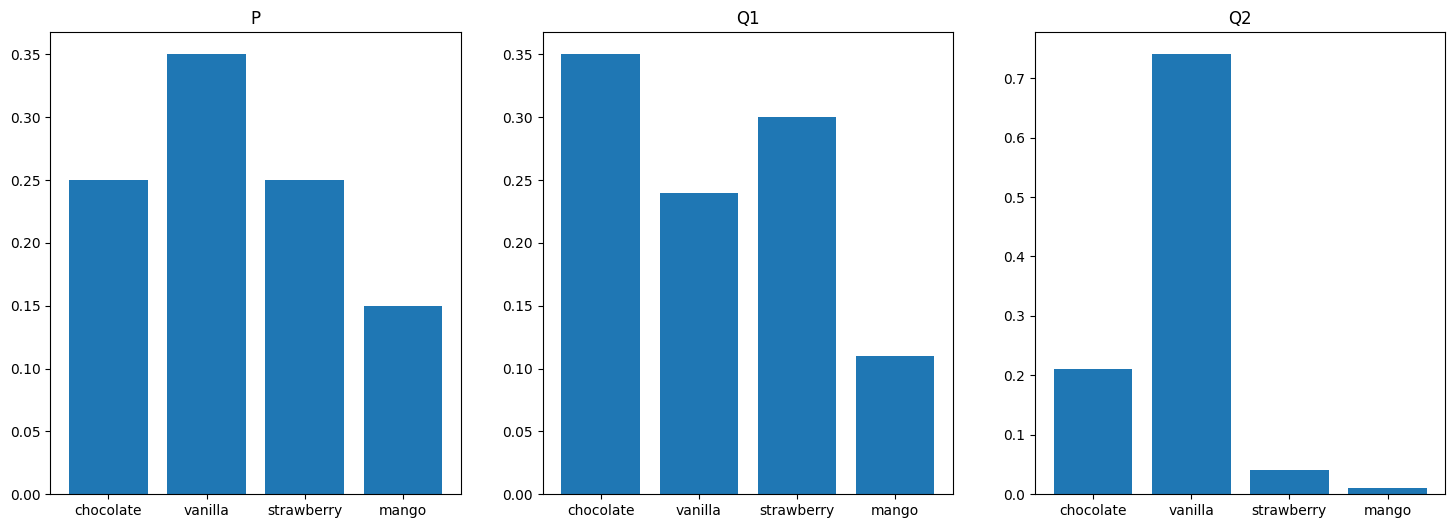

In [ ]:
import matplotlib.pyplot as plt
from typing import List


P = {'chocolate': 0.25, 'vanilla': 0.35, 'strawberry': 0.25, 'mango': 0.15}
Q1 = {'chocolate': 0.35, 'vanilla': 0.24, 'strawberry': 0.30, 'mango': 0.11}
Q2 = {'chocolate': 0.21, 'vanilla': 0.74, 'strawberry': 0.04, 'mango': 0.01}


def draw_histograms(distributions: List[dict], titles: List[str]):
  fig, axs = plt.subplots(1, 3, figsize=(18, 6))

  for i, distribution in enumerate(distributions):
    categories = list(distribution.keys())
    values = list(distribution.values())

    axs[i].bar(categories, values)
    axs[i].set_title(titles[i])


draw_histograms([P, Q1, Q2], ["P", "Q1", "Q2"])

In [ ]:
import torch


def compute_kl_divergence(distribution1: dict, distribution2: dict):
  assert set(distribution1.keys()) == set(distribution2.keys()), "Two distributions must have same support."

  support = distribution1.keys()
  probability_list1 = torch.Tensor([distribution1[x] for x in support])
  probability_list2 = torch.Tensor([distribution2[x] for x in support])

  return -(probability_list1 * torch.log(probability_list2 / probability_list1)).sum()  # compute outcome-wise KL divergence, than sum over them


print(f"D(P|Q1) = {compute_kl_divergence(P, Q1)}")
print(f"D(P|Q2) = {compute_kl_divergence(P, Q2)}")

D(P|Q1) = 0.0488777682185173
D(P|Q2) = 0.6458903551101685


### Relationship between KL Divergence and Cross Entropy

The cross entropy $H(P, Q)$ between distributions P and Q is defined as

<br>

\begin{align*}
  H(P, Q) = - \sum_{x \in 𝕏} P(x) \log Q(x)
\end{align*}

Therefore, by definition,

\begin{align*}
  H(P, Q) = H(P) + D_{KL}(P||Q)
\end{align*}

<br>

### What does this mean for language modeling?
Let's consider $P$ as the human text distribution (which we collect language model train set from), and $Q$ as the language model we are training. As we shall see in the later lectures, we typically train a language model with **cross entropy loss**, i.e., to minimize $H(P,Q)$.

Since H(P) is the inherent entropy of human text distribution (hence irreducible), **minimizing $H(P,Q)$ amounts to minimizing $D_{KL}(P||Q)$, i.e., the distance between $P$ and our learned distribution $Q$.**

### Question: Modify `compute_kl_divergence` to compute the cross entropy between two distributions.

Take a stab at it yourself before revealing the answer below!

### Answer

In [ ]:
def compute_cross_entropy(distribution1: dict, distribution2: dict):
  assert set(distribution1.keys()) == set(distribution2.keys()), "Two distributions must have same support."

  support = distribution1.keys()
  probability_list1 = torch.Tensor([distribution1[x] for x in support])
  probability_list2 = torch.Tensor([distribution2[x] for x in support])

  return -(probability_list1 * torch.log(probability_list2)).sum()

## Part 3: Language Model Basics

### Language Models model the empirical distribution of text
In principle, generative language models such as GPT-2, GPT-3, ... are trained to model the empirical distribution of human text.

* If so, can we measure the likelihood of an arbitrary sequence of text?

Yes! Below, we will try ourselves to compute the likelihood of a text sequence using a modern LM, GPT-2.

<br>

### What is GPT-2?
As the name suggests, GPT-2 is a predecessor of GPT-3 (ChatGPT, GPT-4), ... released by OpenAI in 2019.

![](https://drive.google.com/uc?export=view&id=1ZsTdVzwP0dm_T2iq1_suDq8ogYxD4x82)

GPT-2 comes in different sizes, and today we will use the smallest version, GPT-2 Small with 117M parameters.

* Note: GPT-3 Davinci has 175B parameters!


Pretrained Models such as GPT-2 can be downloaded from [Huggingface Model Hub](https://huggingface.co/).

Below, we prepared a high-level interface to play with GPT-2. You don't have to understand this code line by line, stay tuned for next tutorial on Torch / Huggingface!

**NOTE: Change Colab resources to T4 GPU**


### High-level Interface

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

class GPT2:
  def __init__(self):
    self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
    self.token_list = self.tokenizer.convert_ids_to_tokens(range(len(self.tokenizer)))

    self.model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
    self.model.eval()

  def compute_likelihood(self, text: str):
    inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)

    with torch.no_grad():
      outputs = self.model(**inputs, labels=inputs.input_ids)

    return torch.exp(-outputs.loss * (inputs.input_ids.size(-1) - 1)).item()

  def tokenize(self, text: str):
    tokenized_sequence = self.tokenizer.convert_ids_to_tokens(
        self.tokenizer(text).input_ids
    )

    return tokenized_sequence

  def add_new_token(self, previous_text: str, new_token: str):
    previous_input_ids = self.tokenizer(previous_text).input_ids
    new_token_id = self.tokenizer.convert_tokens_to_ids(new_token)

    new_input_ids = previous_input_ids + [new_token_id]
    new_text = self.tokenizer.decode(new_input_ids)

    return new_text

  def compute_next_token_distribution(self, text: str):
    inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)
    with torch.no_grad():
      last_token_logits = self.model(**inputs).logits[0, -1, :]
      probabilities = torch.softmax(last_token_logits, dim=-1)

    return {
        token: prob
        for token, prob in zip(self.token_list, probabilities)
    }


gpt2 = GPT2()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Computing likelihood of sequence using LM


Since GPT-2 models text distribution, you can measure the likelihood of whatever text you give as input.

### Exercise: Try to find a sentence with higher likelihood that starts with "Hi,".

In [ ]:
likely_sentence = "Hi, what's up?"
unlikely_sentence = "Hi, bye you are!"

print(f"Likelihood of {likely_sentence}: {gpt2.compute_likelihood(likely_sentence)}")
print(f"Likelihood of {unlikely_sentence}: {gpt2.compute_likelihood(unlikely_sentence)}")

Likelihood of Hi, what's up?: 3.324063300169655e-06
Likelihood of Hi, bye you are!: 1.0171533754155249e-11


### What's happening under the hood?

To calculate the probability of a sequence, we use the **chain rule** to break down the probability into the product of conditional probabilities, one for each token.

Recall that for two events A and B, the chain rule states that

$$P(A\cap B)=P(B\mid A)P(A)$$

In words, the probability of event $A$ and event $B$ happening is calculated as the probability of $A$ happening, times the probability of $B$ happening given that $A$ happened.

Applying this to language modeling, you can think of each event as a particular token being generated at a particular index. So, the probability of a text $x_1,x_2,...,x_n$ would be given by

$$P(x_1,x_2,...,x_n)=P(x_1)\cdot P(x_2\mid x_1)\cdot P(x_3\mid x_1,x_2)\cdots P(x_n\mid x_1,...,x_{n-1})=\prod_{t=1}^n P(x_t\mid x_{<t})$$

In summary, we decompose the probability of a text into the conditional probability of each token given the previous context.

Let's look at a step-by-step example for computing the likelihood of a given sentence using the chain rule. Note that "Ġ" just corresponds to a space at the beginning of tokens.

In [ ]:
sentence = "Hi, how are you?"
token_sequences = gpt2.tokenize(sentence)

print(f'These are the tokens in "{sentence}": {token_sequences}')

These are the tokens in "Hi, how are you?": ['Hi', ',', 'Ġhow', 'Ġare', 'Ġyou', '?']


In [ ]:
import math

sequence_so_far = "Hi"  # the beginning-of-sequence token
likelihood_list = []

for i, token in enumerate(token_sequences[1:]):
  next_token_distribution = gpt2.compute_next_token_distribution(sequence_so_far)
  likelihood = next_token_distribution[token]
  likelihood_list.append(likelihood)

  print(f"P({token.replace('Ġ', '')}|{sequence_so_far}) = {likelihood}")

  sequence_so_far = gpt2.add_new_token(sequence_so_far, token)

print()
print(f"P({sequence_so_far}) = {math.prod(likelihood_list)}")

P(,|Hi) = 0.06419573724269867
P(how|Hi,) = 0.008142274804413319
P(are|Hi, how) = 0.05635732412338257
P(you|Hi, how are) = 0.663574755191803
P(?|Hi, how are you) = 0.14008843898773193

P(Hi, how are you?) = 2.7383846372686094e-06


A small caveat: note that the probability we just computed is technically not the probability of the whole sequence, since we exclude the first token! In practice, language models are only trained to start predicting the second token given the first, and so on.

### Generating text with greedy decoding
Because LMs predict the probability distribution over the vocabulary for the next-word, we can actually use it to do more than score the probability of a given text — we can use it to generate _novel_ text!

First let's consider **greedy decoding**. As the name suggests, this strategy greedily takes the _most likely_ next-token predicted by the LM at each time step.

In [ ]:
sequence_so_far = "Hi"
step = 1

Run the next cell many times to generate text, one token at a time!

In [ ]:
print(f'Step {step}')
next_token_distribution = gpt2.compute_next_token_distribution(sequence_so_far)
next_token, token_prob = max(next_token_distribution.items(), key=lambda x: x[1])  # choose the token with largest probability

print(f"Argmax token: {next_token}, Probability: {token_prob}")

sequence_so_far = gpt2.add_new_token(sequence_so_far, next_token)
print(sequence_so_far)
step += 1

Step 4
Argmax token: Ġsorry, Probability: 0.08845137059688568
Hi. I'm sorry


### Sampling

In practice, greedy decoding is often not the best way to generate text. Oftentimes we wish to produce many **diverse** outputs for the same input!

Therefore, another generation strategy is to _sample_ from the predicted probability distribution rather than always predicting the most-likely token. Recall that a good LM should assign higher probability to reasonable next-tokens than those that are very unlikely to occur next in the current context.

In [ ]:
sequence_so_far = "Hi"
step = 1

To sample generations instead, we just need to change our `max` function into sampling from categorical distribution, using `torch.multinomial`!

In [ ]:
print(f'Step {step}')
next_token_distribution = gpt2.compute_next_token_distribution(sequence_so_far)
next_token_probs = torch.Tensor(list(next_token_distribution.values()))
next_token_id = torch.multinomial(next_token_probs, 1)
next_token = gpt2.token_list[next_token_id]
token_prob = next_token_distribution[next_token]

print(f"Argmax token: {next_token}, Probability: {token_prob}")

sequence_so_far = gpt2.add_new_token(sequence_so_far, next_token)
print(sequence_so_far)
step += 1

Step 3
Argmax token: Ġputting, Probability: 0.00012229886488057673
Hi to everyone putting


This time, try starting over and generating your sequence again. You should be able to get a different text sequence each time (at least with enough time steps)!

### Concluding notes on generation

Greedy decoding and sampling are just two of many, many ways to decode text from the next-token probability distributions of language models, and is an active area of research. The optimal decoding strategy may depend on various factors, like the goal of the generation (accuracy or creativity?), the desired style (how can we steer LMs to be less toxic?), or any number of other constraints (how can we ensure that this set of words appear, but other ones do not?).

If this direction interests you, feel free to brainstorm about potential decoding strategies you might explore for the final project!